In [1]:
import collections
import itertools
import json
import pathlib

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import ticker
import ml_collections
import numpy as np
import pandas as pd
import torch

import hier
import hier_torch
import infer
import main
import metrics
import progmet
import tree_util

In [2]:
Trial = collections.namedtuple('Trial', ['root', 'config_file', 'model_file'])

In [101]:
# # Flat softmax with label smoothing.
# PLOT_DIR = 'output/plots/sweep_label_smoothing'
# EXP_DIR = pathlib.Path('/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini')
# EXPERIMENT_PATTERNS = [
#     'flat_softmax-lr-0.01-b-64-wd-0.0003-ep-20',
#     'flat_softmax-ls-*-lr-0.01-b-64-wd-0.0003-ep-20',
# ]
# config_to_hparams = lambda c: (c.train.label_smoothing,)
# predicate = lambda ls: ls < 0.6


# # Multilabel focal loss.
# PLOT_DIR = 'output/plots/sweep_multilabel_focal'
# EXP_DIR = pathlib.Path('/mnt/ssd1/projects/2022-01-hierarchical/experiments')
# EXPERIMENT_PATTERNS = [
#     '2022-03-31-inat21mini-dgx/multilabel_focal-*-*-lr-0.01-b-64-wd-0.0003-ep-20',
#     '2022-03-31-inat21mini/multilabel_focal-0.*-0-lr-0.01-b-64-wd-0.0003-ep-20',
#     '2022-03-31-inat21mini/multilabel_focal-none-*-0-lr-0.01-b-64-wd-0.0003-ep-20',
# ]
# config_to_hparams = lambda c: (c.train.focal_gamma, c.train.focal_alpha)
# predicate = lambda gamma, alpha: alpha >= 0.4 and gamma > 0


# # Multilabel focal loss, including `loss_weighting`.
# PLOT_DIR = 'output/plots/sweep_multilabel_focal'
# EXP_DIR = pathlib.Path('/mnt/ssd1/projects/2022-01-hierarchical/experiments')
# EXPERIMENT_PATTERNS = [
#     '2022-03-31-inat21mini-dgx/multilabel_focal-*-*-lr-0.01-b-64-wd-0.0003-ep-20',
#     '2022-03-31-inat21mini/multilabel_focal-inv_sqrt-*-*-lr-0.01-b-64-wd-0.0003-ep-20',
# ]
# config_to_hparams = lambda c: (c.train.focal_gamma, c.train.focal_alpha, c.train.loss_weighting)
# predicate = lambda gamma, alpha, loss_weighting: True


# # Bertinetto HXE loss.
# PLOT_DIR = 'output/plots/sweep_hxe'
# EXP_DIR = pathlib.Path('/mnt/ssd1/projects/2022-01-hierarchical/experiments')
# EXPERIMENT_PATTERNS = [
#     '2022-03-31-inat21mini/flat_softmax-lr-0.01-b-64-wd-0.0003-ep-20',
#     # '2022-03-31-inat21mini/flat_bertinetto-*-lr-0.01-b-64-wd-0.0003-ep-20',
#     '2022-05-12-hxe-sweep/flat_bertinetto-*-lr-0.01-b-64-wd-0.0003-ep-20',
# ]
# config_to_hparams = lambda c: (c.train.hxe_alpha,)
# predicate = lambda alpha: True


# Deep RTC (cut prob).
PLOT_DIR = 'output/plots/sweep_deep_rtc'
EXP_DIR = pathlib.Path('/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini')
EXPERIMENT_PATTERNS = [
    'share_random_cut-0.01-lr-0.01-b-64-wd-0.0003-ep-20',
    'share_random_cut-0.02-lr-0.01-b-64-wd-0.0003-ep-20',
    'share_random_cut-0.05-lr-0.01-b-64-wd-0.0003-ep-20',
    'share_random_cut-0.1-lr-0.01-b-64-wd-0.0003-ep-20',
    'share_random_cut-0-lr-0.01-b-64-wd-0.0003-ep-20',
]
config_to_hparams = lambda c: (c.train.random_cut_prob,)
predicate = lambda alpha: True


# # Margin (scale).
# PLOT_DIR = 'output/plots/sweep_soft_margin'
# EXP_DIR = pathlib.Path('/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini')
# EXPERIMENT_PATTERNS = [
#     'soft_margin-incorrect-*lr-0.01-b-64-wd-0.0003-ep-20',
# ]
# config_to_hparams = lambda c: (c.train.margin_tau,)
# predicate = lambda tau: True

In [102]:
def update_config(config):
    if not hasattr(config.train, 'loss_weighting'):
        setattr(config.train, 'loss_weighting', 'none')
    if not hasattr(config.train, 'margin_tau'):
        setattr(config.train, 'margin_tau', 1.0)
    return config  # For convenience.

In [103]:
experiments = {
    path.name: Trial(
        root=path,
        config_file=path / 'config.json',
        model_file=path / 'checkpoints/epoch-0020.pth')
    for path in sorted(itertools.chain.from_iterable(
        pathlib.Path(EXP_DIR).glob(pattern) for pattern in EXPERIMENT_PATTERNS))
    if (path / 'checkpoints/epoch-0020.pth').exists()
}
list(experiments)

['share_random_cut-0-lr-0.01-b-64-wd-0.0003-ep-20',
 'share_random_cut-0.01-lr-0.01-b-64-wd-0.0003-ep-20',
 'share_random_cut-0.02-lr-0.01-b-64-wd-0.0003-ep-20',
 'share_random_cut-0.05-lr-0.01-b-64-wd-0.0003-ep-20',
 'share_random_cut-0.1-lr-0.01-b-64-wd-0.0003-ep-20']

In [104]:
# Get params from JSON file not filename (less prone to human error).

configs = {}
for k, experiment in experiments.items():
    with open(experiment.config_file) as f:
        configs[k] = update_config(ml_collections.ConfigDict(json.load(f)))

experiment_hparams = {k: config_to_hparams(c) for k, c in configs.items()}
experiment_hparams

{'share_random_cut-0-lr-0.01-b-64-wd-0.0003-ep-20': (0.0,),
 'share_random_cut-0.01-lr-0.01-b-64-wd-0.0003-ep-20': (0.01,),
 'share_random_cut-0.02-lr-0.01-b-64-wd-0.0003-ep-20': (0.02,),
 'share_random_cut-0.05-lr-0.01-b-64-wd-0.0003-ep-20': (0.05,),
 'share_random_cut-0.1-lr-0.01-b-64-wd-0.0003-ep-20': (0.1,)}

In [105]:
# Filter using predicate.

experiment_hparams = {k: hparams for k, hparams in experiment_hparams.items() if predicate(*hparams)}
experiments = {k: experiments[k] for k in experiment_hparams}
experiment_hparams

{'share_random_cut-0-lr-0.01-b-64-wd-0.0003-ep-20': (0.0,),
 'share_random_cut-0.01-lr-0.01-b-64-wd-0.0003-ep-20': (0.01,),
 'share_random_cut-0.02-lr-0.01-b-64-wd-0.0003-ep-20': (0.02,),
 'share_random_cut-0.05-lr-0.01-b-64-wd-0.0003-ep-20': (0.05,),
 'share_random_cut-0.1-lr-0.01-b-64-wd-0.0003-ep-20': (0.1,)}

In [106]:
# Arrange by key, ensure unique.

hparams_to_key = dict(sorted((v, k) for k, v in experiment_hparams.items()))
assert len(hparams_to_key) == len(experiment_hparams), 'hparams not unique'

colors = dict(zip(
    hparams_to_key,
    map(matplotlib.cm.get_cmap('tab10'), itertools.count())))

hparams_to_key

{(0.0,): 'share_random_cut-0-lr-0.01-b-64-wd-0.0003-ep-20',
 (0.01,): 'share_random_cut-0.01-lr-0.01-b-64-wd-0.0003-ep-20',
 (0.02,): 'share_random_cut-0.02-lr-0.01-b-64-wd-0.0003-ep-20',
 (0.05,): 'share_random_cut-0.05-lr-0.01-b-64-wd-0.0003-ep-20',
 (0.1,): 'share_random_cut-0.1-lr-0.01-b-64-wd-0.0003-ep-20'}

In [107]:
device = torch.device('cuda')

In [108]:
import configs.inaturalist2021mini

base_config = configs.inaturalist2021mini.get_config()
base_config.dataset_root = '/home/jack/data/manual/inaturalist2021/'

_, eval_dataset, tree, _, _, eval_label_map = main.make_datasets(base_config)

eval_loader = torch.utils.data.DataLoader(
    dataset=eval_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2)

In [109]:
is_leaf = tree.leaf_mask()
specificity = -tree.num_leaf_descendants()
not_trivial = (tree.num_children() != 1)
subtract_children_fn = hier_torch.SubtractChildren(tree)

In [110]:
infer_fns = {
    'leaf': lambda p: infer.argmax_where(p, is_leaf),
    'majority': lambda p: infer.argmax_with_confidence(specificity, p, 0.5, not_trivial),
    # 'exclusive': lambda p: np.argmax(subtract_children_fn(torch.from_numpy(p)).numpy(), axis=-1),
}

markers = {
    'leaf': 'o',
    'majority': '^',
    # 'exclusive': 'd',
}

In [111]:
info_metric = metrics.UniformLeafInfoMetric(tree)
depth_metric = metrics.DepthMetric(tree)

metric_fns = {
    'exact': lambda gt, pr: pr == gt,
    'correct': metrics.IsCorrect(tree),
    'info_excess': info_metric.excess,
    'info_deficient': info_metric.deficient,
    'info_dist': info_metric.dist,
    'info_recall': info_metric.recall,
    'info_precision': info_metric.precision,
    'depth_excess': depth_metric.excess,
    'depth_deficient': depth_metric.deficient,
    'depth_dist': depth_metric.dist,
    'depth_recall': depth_metric.recall,
    'depth_precision': depth_metric.precision,
}

metric_titles = {
    'exact': 'Exact',
    'correct': 'Correct',
    'info_recall': 'Information Recall',
    'info_precision': 'Information Precision',
    'depth_recall': 'Depth Recall',
    'depth_precision': 'Depth Precision',
    'info_lca': 'LCA Information',
    'depth_lca': 'LCA Depth',
}

In [112]:
def apply_model(net, pred_fn, min_threshold, limit=None, temperature=None):
    # Per-example predictions.

    outputs = {
        'gt': [],  # Node in hierarchy.
        'pred': {method: [] for method in infer_fns},
    }
    # Sequence-per-example predictions. Cannot be concatenated due to ragged shape.
    seq_outputs = {
        'pred': [],
        'prob': [],
    }

    net.eval()
    with torch.inference_mode():
        meter = progmet.ProgressMeter('apply', interval_time=5)
        for minibatch in itertools.islice(meter(eval_loader), limit):
            inputs, gt_labels = minibatch
            theta = net(inputs.to(device))
            if temperature:
                theta = theta / temperature
            prob = pred_fn(theta).cpu().numpy()
            pred = {}
            for name, infer_fn in infer_fns.items():
                pred[name] = infer_fn(prob)
            gt_node = eval_label_map.to_node[gt_labels]
            pred_seqs = [
                infer.pareto_optimal_predictions(specificity, p, min_threshold, not_trivial)
                for p in prob
            ]
            prob_seqs = [prob[i, pred_i] for i, pred_i in enumerate(pred_seqs)]
            # Caution: Predictions are *not* truncated.

            outputs['gt'].append(gt_node)
            for method in infer_fns:
                outputs['pred'][method].append(pred[method])
            seq_outputs['pred'].extend(pred_seqs)
            seq_outputs['prob'].extend(prob_seqs)

    # Concatenate results from minibatches.
    leaf_predicate = lambda x: not isinstance(x, dict)  # Treat lists as values, not containers.
    outputs = tree_util.tree_map(np.concatenate, outputs, is_leaf=leaf_predicate)

    return outputs, seq_outputs

In [113]:
def assess_predictions(outputs, seq_outputs):
    gt = outputs['gt']
    pred = outputs['pred']
    pred_seq = seq_outputs['pred']
    prob_seq = seq_outputs['prob']

    # Evaluate predictions for each method.
    pred = {
        method: hier.truncate_at_lca(tree, gt, pr)
        for method, pr in pred.items()
    }
    pred_metrics = {
        method: {field: np.mean(metric_fn(gt, pr))
                 for field, metric_fn in metric_fns.items()}
        for method, pr in pred.items()
    }

    # Evaluate predictions in Pareto sequence.
    find_lca = hier.FindLCA(tree)
    specificity_seq = [specificity[pr_i] for pr_i in pred_seq]
    pred_seq = [hier.truncate_given_lca(gt_i, pr_i, find_lca(gt_i, pr_i)) for gt_i, pr_i in zip(gt, pred_seq)]
    metric_values_seq = {
        field: [metric_fn(gt_i, pr_i) for gt_i, pr_i in zip(gt, pred_seq)]
        for field, metric_fn in metric_fns.items()
    }
    pareto_scores, pareto_totals = metrics.operating_curve(prob_seq, metric_values_seq)
    pareto_means = {k: v / len(gt) for k, v in pareto_totals.items()}

    return pred_metrics, pareto_scores, pareto_means

In [114]:
def resample_threshold(scores, metric, x):
    return metric[np.searchsorted(-scores, -x)]

In [115]:
# Initialize results if not defined.
try:
    results
except NameError:
    results = {}  # Not defined.

In [116]:
MIN_THRESHOLD = None  # Values less than 0.5 may increase runtime significantly.
LIMIT = None
TEMPERATURE = 10.0  # None

score_grid = np.flip(np.linspace(0, 1, 10001))

for name, experiment in experiments.items():
    if name in results:
        print('cached:', name)
        continue

    # Load model.
    with open(experiment.config_file, 'r') as f:
        config = update_config(ml_collections.ConfigDict(json.load(f)))
    num_outputs = main.get_num_outputs(config.predict, tree)
    net = main.make_model(config.model, num_outputs)
    missing_keys, unexpected_keys = net.load_state_dict(torch.load(experiment.model_file), strict=True)
    assert not missing_keys
    assert not unexpected_keys

    net.to(device)
    _, pred_fn = main.make_loss(config, tree, device)
    outputs, seq_outputs = apply_model(
        net, pred_fn, min_threshold=MIN_THRESHOLD, limit=LIMIT, temperature=TEMPERATURE)
    pred_metrics, pareto_scores, pareto_metrics = assess_predictions(outputs, seq_outputs)
    trial_results = {
        'pred_metrics': pred_metrics,
        'pareto_scores': pareto_scores,
        'pareto_metrics': pareto_metrics,
    }

    # Re-sample the Pareto front; also keeps the memory footprint down.
    trial_results.update({
        'pareto_scores': score_grid[1:],
        'pareto_metrics': {
            field: resample_threshold(
                trial_results['pareto_scores'],
                trial_results['pareto_metrics'][field],
                score_grid)
            for field in trial_results['pareto_metrics']
        },
    })
    results[name] = trial_results

cached: share_random_cut-0-lr-0.01-b-64-wd-0.0003-ep-20
cached: share_random_cut-0.01-lr-0.01-b-64-wd-0.0003-ep-20
cached: share_random_cut-0.02-lr-0.01-b-64-wd-0.0003-ep-20
cached: share_random_cut-0.05-lr-0.01-b-64-wd-0.0003-ep-20
cached: share_random_cut-0.1-lr-0.01-b-64-wd-0.0003-ep-20


In [117]:
INTEGRALS = {
    'AC(depth)': ('depth_recall', 'correct'),
    'AC(info)': ('info_recall', 'correct'),
    'AP(depth)': ('depth_recall', 'depth_precision'),
    'AP(info)': ('info_recall', 'info_precision'),
    'AC(exact)': ('exact', 'correct'),
}

auc = {
    integral_key: {
        name: metrics.pareto_integrate(
            results[name]['pareto_metrics'][x],
            results[name]['pareto_metrics'][y])
        for name in experiments if name in results
    } for integral_key, (x, y) in INTEGRALS.items()
}

auc = pd.DataFrame(auc)
auc = auc.set_index(auc.index.map(experiment_hparams)).sort_index()
auc.style.format('{:.1%}'.format)

,AC(depth),AC(info),AP(depth),AP(info),AC(exact)
0.000000,66.6%,61.0%,74.6%,66.2%,46.2%
0.010000,66.3%,60.4%,74.6%,66.0%,45.0%
0.020000,65.8%,59.8%,74.2%,65.6%,44.2%
0.050000,64.4%,58.1%,73.2%,64.1%,42.0%
0.100000,61.5%,54.8%,71.1%,61.1%,37.6%


In [118]:
auc.sort_values('AP(info)', ascending=False).style.format('{:.1%}'.format)

,AC(depth),AC(info),AP(depth),AP(info),AC(exact)
0.000000,66.6%,61.0%,74.6%,66.2%,46.2%
0.010000,66.3%,60.4%,74.6%,66.0%,45.0%
0.020000,65.8%,59.8%,74.2%,65.6%,44.2%
0.050000,64.4%,58.1%,73.2%,64.1%,42.0%
0.100000,61.5%,54.8%,71.1%,61.1%,37.6%


In [119]:
INTERCEPTS = [
    'depth_recall',
    'info_recall',
    'exact',
]

CORRECT = [95, 90]

recalls = {
    (c, y): {
        name: metrics.pareto_intercept(
            results[name]['pareto_metrics']['correct'],
            results[name]['pareto_metrics'][y],
            c / 100)
        for name in results
    } for c in CORRECT for y in INTERCEPTS
}

recalls = pd.DataFrame(recalls)
recalls = recalls.set_index(recalls.index.map(experiment_hparams)).sort_index()
recalls.style.format('{:.1%}'.format)

In [120]:
recalls.sort_values((90, 'info_recall'), ascending=False).style.format('{:.1%}'.format)

In [121]:
def plot_metrics(x, y, tickres=None, is_pr=True, save=False):
    plt.figure(figsize=(5, 4))
    for hparams, name in hparams_to_key.items():
        pred_metrics = results[name]['pred_metrics']
        pareto_scores = results[name]['pareto_scores']
        pareto_metrics = results[name]['pareto_metrics']
        ge = np.concatenate(([True], pareto_scores >= 0.5))
        le = np.concatenate(([False], pareto_scores <= 0.5))
        plt.plot(pareto_metrics[x][ge], pareto_metrics[y][ge],
                 color=colors[hparams], label=', '.join(map(str, hparams)))
        plt.plot(pareto_metrics[x][le], pareto_metrics[y][le],
                 color=colors[hparams], linestyle='--')
        for method in ['leaf', 'majority']:  # pred_metrics.items():
            plt.plot(pred_metrics[method][x], pred_metrics[method][y],
                     color=colors[hparams], marker=markers[method],
                     markerfacecolor='none')

    ax = plt.gca()
    if is_pr:
        plt.xlim(left=0)
        plt.ylim(top=1)
        # plt.ylim(np.clip(plt.ylim(), 0, 1))
        # plt.xlim(np.clip(plt.xlim(), 0, 1))
    if tickres:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(tickres))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(tickres))
    # plt.axis('equal')
    # plt.gca().set_aspect(1)
    plt.grid()
    plt.xlabel(metric_titles.get(x, x))
    plt.ylabel(metric_titles.get(y, y))
    plt.legend()

    if save:
        pathlib.Path(PLOT_DIR).mkdir(parents=True, exist_ok=True)
        plt.savefig(pathlib.Path(PLOT_DIR) / f'{x}-{y}.pdf')

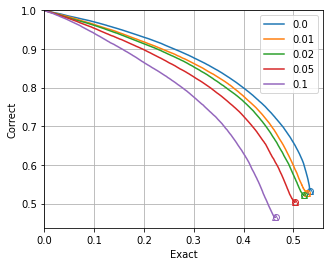

In [122]:
plot_metrics('exact', 'correct', save=True)

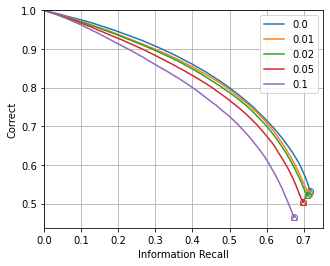

In [123]:
plot_metrics('info_recall', 'correct', save=True)

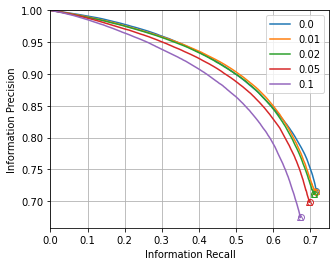

In [124]:
plot_metrics('info_recall', 'info_precision', save=True)

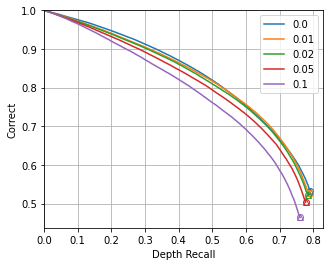

In [125]:
plot_metrics('depth_recall', 'correct', save=True)

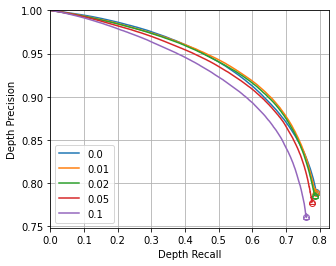

In [126]:
plot_metrics('depth_recall', 'depth_precision', save=True)